# 02 - Data from the Web

We start importing all the libraries that we are going to use.

In [1]:
import math
import pandas as pd
import numpy as np
import requests
import scipy.stats as norm
import matplotlib.pyplot as plt
from scipy import stats
from bs4 import BeautifulSoup 


Now we will generate the base of our futures requests

In [2]:
payloadform = {'ww_i_reportModel': '133685247'}
# The base of the url that we will use always
isa_baseurl = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS'
# We generate the form url
isa_formurl= isa_baseurl + ".filter"
# We make the request to isacademis to obtain the form
r = requests.get(isa_formurl, params=payloadform)
# We check what we the url and the response of the server
s = r.url + " " + str(r.status_code)


In the next steps, we will parse the HTML of the form. Here we see the main idea of how we will do it. We are doing this to facilitate the future "get" petitions

In [3]:
soup = BeautifulSoup(r.text, 'html.parser')
inputs = soup.select('form input') # eWe extract the inputs from the form 
print(inputs[5]['name'])
tags=inputs[6].select('option') # extraemos las posibles opcicones 
print(tags[1].contents) 
inputs[5].select('option')[9].contents[0] 

zz_x_UNITE_ACAD
['2016-2017']


'Informatique'

We prepare a new payload (the params of the get petition) structure.


In [4]:
# Model of the params of the request
payloadfix = {'ww_x_GPS': '-1', 'ww_i_reportModel': '133685247', 'ww_i_reportModelXsl': '133685270', 'ww_x_UNITE_ACAD': '','ww_x_PERIODE_ACAD': '', 'ww_x_PERIODE_PEDAGO': '','ww_x_HIVERETE': '' }
# New url, for getting the table with the data.
isa_dataurl = isa_baseurl + ".html"
payloadfix['ww_x_UNITE_ACAD'] = inputs[5].select('option')[9]['value']



We create a function that download the data form the isacademia and parse it, returning a DataFrame.

In [5]:
# Here we will need to parse the html using BeautifulSoup library.
# The data that we want comes in a html table, won't be really hard to parse it.


def extractTable(year,sem):
    payloadfix['ww_x_PERIODE_ACAD'] = inputs[6].select('option')[year]['value']
    payloadfix['ww_x_PERIODE_PEDAGO'] = inputs[7].select('option')[sem]['value']#[7]==bach6
    if(sem==1):
        payloadfix['ww_x_HIVERETE'] = inputs[8].select('option')[1]['value']
    else:
        payloadfix['ww_x_HIVERETE'] = inputs[8].select('option')[2]['value']
    
    r = requests.get(isa_dataurl, params=payloadfix)
    Data = BeautifulSoup(r.text, 'html.parser') 
    """Extract the table from HTML into a pandas Dataframe."""
    BStable = BeautifulSoup(r.text, 'html.parser').find('table')
    
    BSRows = BStable.findAll('tr')
    # BSrows[0] is just the title of the table, so we ignore it.
    headerBSRow = BSRows[1]
    headers = [th.string for th in headerBSRow]
    # We drop the last column, because it's always empty (originally it is used to make the HTML table look better).
    rows = [[tr.string for tr in BSRow.findAll('td')[:-1]] for BSRow in BSRows[2:]]
    # return pd.DataFrame(data=rows, columns=headers)[headers[-1]]
    return pd.DataFrame(data=rows, columns=headers)


In this next step we will use de above function to download all the bachelor data and count how many students finished the bachelor, checking which ones are female and 
males. 

In [6]:
year=10
semester=1
data=[]
gender_beg=[]
gender_end=[]
i=0
while(year>0):
    course=extractTable(year,semester)
    course_aux=course['No Sciper']
    course_aux.name=str(i)
    data.append(course_aux)
    course_aux=course['Civilité']
    course_aux.name=str(i)
    if(semester==1):
        gender_beg.append(course_aux)
        semester=7
    else:
        gender_end.append(course_aux)
        year-=1
        semester=1
    i+=1
n=0
#remove last two years
df_beg={}
df_end={}
total_enrollments=0
index=0
for i in data:
    if(index%2==0):
        if(index/2>8):
            index+=1
            continue
        df_beg[str(int(index/2))]=i
        total_enrollments+=len(i)
    else:
        df_end[str(int((index+1)/2-1))]=i
    index+=1
index=0#i current semester[0..7]
index2=1#j next semester[1..7] for bachelor1

#NOTE: we know all the students can enroll to the bach1, and then pass to the 2nd bach or not.
#and you're supposed to enroll to the same bachelor the year after
#but failing on the bach1 does not imply that someone's gonna enroll to the next year.
#you can enroll two years after failing too if you're a mess, your money's always welcome.
#so, it's the same as passing, but we can't figured out if you really pass.Just knowing your last enrollment.
#we should check the master1 instead of bach6 but it's out of context
while(index<len(df_beg)-1):
    while(index2<len(df_beg)):
#         print('index2:',index2,'\tlen(gender[index]):',len(gender_beg[index2]))
        for i in df_beg[str(index2)].values:
            if i in df_beg[str(index)].values:
#                print(i)
                found=df_beg[str(index2)][df_beg[str(index2)]==i] #give us the subserie found
                found=found.index[0]#get index from serie
                gender_beg[index2]=gender_beg[index2].drop(found)
                df_beg[str(index2)]=df_beg[str(index2)].drop(found)#drop repeated student(he was enrolled the previous year)
        index2+=1
    index+=1
    index2=index+1
#fetch all the females/males enrolled to bach1
males_beg=[]
males_aux=0
females_beg=[]
females_aux=0
males_tot_beg=0
females_tot_beg=0
i=0
while(i<len(gender_beg)):
    for j in gender_beg[i].values:
        if(j=='Monsieur'):
            males_aux+=1
        elif(j=='Madame'):
            females_aux+=1
    males_beg.append([i,males_aux])
    females_beg.append([i,females_aux])
    males_tot_beg+=males_aux
    females_tot_beg+=females_aux
    males_aux=0
    females_aux=0
    i+=1
print('males enrolled to bachelor1: ',males_tot_beg,'\nmales enrolled to bach1 per sem: ',males_beg)
print('females enrolled to bachelor1: ',females_tot_beg,'\nfemales enrolled to bach1 per sem: ',females_beg)


#fetch all the females/males enrolled to bach6
males_end=[]
males_aux=0
females_end=[]
females_aux=0
males_tot_end=0
females_tot_end=0
i=0
while(i<len(gender_end)):
    for j in gender_end[i].values:
        if(j=='Monsieur'):
            males_aux+=1
        elif(j=='Madame'):
            females_aux+=1
    males_end.append([i,males_aux])
    females_end.append([i,females_aux])
    males_tot_end+=males_aux
    females_tot_end+=females_aux
    males_aux=0
    females_aux=0
#     j=0
    i+=1
print('males enrolled to bachelor6: ',males_tot_end,'\nmales enrolled to bach6 per sem: ',males_end)
print('females enrolled to bachelor6: ',females_tot_end,'\nfemales enrolled to bach6 per sem: ',females_end)

df_beg=pd.DataFrame(df_beg)
df_end=pd.DataFrame(df_end)
print('ending df')

males enrolled to bachelor1:  1252 
males enrolled to bach1 per sem:  [[0, 86], [1, 75], [2, 88], [3, 106], [4, 110], [5, 144], [6, 147], [7, 156], [8, 134], [9, 206]]
females enrolled to bachelor1:  133 
females enrolled to bach1 per sem:  [[0, 4], [1, 7], [2, 9], [3, 10], [4, 13], [5, 9], [6, 16], [7, 14], [8, 21], [9, 30]]
males enrolled to bachelor6:  621 
males enrolled to bach6 per sem:  [[0, 35], [1, 49], [2, 56], [3, 48], [4, 49], [5, 78], [6, 79], [7, 110], [8, 95], [9, 22]]
females enrolled to bachelor6:  43 
females enrolled to bach6 per sem:  [[0, 3], [1, 2], [2, 4], [3, 4], [4, 3], [5, 3], [6, 7], [7, 6], [8, 9], [9, 2]]
ending df


In this second itereation we extract all the important information for the DataForm we got before. With this information we will be able to answer the question of the exercise.

In [7]:

index=0#for bachelor1 dataframe
index2=2#for bachelor6 dataframe
#while(index<len(df_beg) and index2<len(df_end)):
#print(type(df_beg[str(index)]))
three_aux=0
three_males_aux=0
three_females_aux=0
three_males_tot=0
three_females_tot=0
three_yrs_tot=0
three_yrs_males=[]
three_yrs_females=[]
three_yrs=[]#we're gonna fetch (beginyear,endyear,total)
four_aux=0
four_males_aux=0
four_females_aux=0
four_males_tot=0
four_females_tot=0
four_yrs=[]
four_yrs_males=[]
four_yrs_females=[]
four_yrs_tot=0
five_aux=0
five_males_aux=0
five_females_aux=0
five_males_tot=0
five_females_tot=0
five_yrs=[]
five_yrs_females=[]
five_yrs_males=[]
five_yrs_tot=0
six_aux=0
six_males_aux=0
six_females_aux=0
six_males_tot=0
six_females_tot=0
six_yrs=[]
six_yrs_males=[]
six_yrs_females=[]
six_yrs_tot=0
total_passed=0
while(index<len(df_beg)-2):
    if(index2==10):
        index+=1
        index2=index+2
    if(index2==10):
        break
    years=index2-index+1
    for n,i in enumerate(df_end[str(index2)].values):
        if i in df_beg[str(index)].values:
            total_passed+=1
            if years==3:  
                if(gender_end[index2][n]=='Monsieur'):
                    three_males_aux+=1
                elif(gender_end[index2][n]=='Madame'):
                    three_females_aux+=1
                three_yrs_tot+=1
                three_aux+=1
            elif years==4:
                if(gender_end[index2][n]=='Monsieur'):
                    four_males_aux+=1
                elif(gender_end[index2][n]=='Madame'):
                    four_females_aux+=1
                four_yrs_tot+=1
                four_aux+=1
            elif years==5:
                if(gender_end[index2][n]=='Monsieur'):
                    five_males_aux+=1
                elif(gender_end[index2][n]=='Madame'):
                    five_females_aux+=1
                five_yrs_tot+=1
                five_aux+=1
            elif years==6:
                if(gender_end[index2][n]=='Monsieur'):
                    six_males_aux+=1
                elif(gender_end[index2][n]=='Madame'):
                    six_females_aux+=1
                six_yrs_tot+=1
                six_aux+=1
    if years==3:
        three_yrs.append([index,index2,three_aux])
        three_yrs_males.append([index,index2,three_males_aux])
        three_yrs_females.append([index,index2,three_females_aux])
        three_males_tot+=three_males_aux
        three_females_tot+=three_females_aux
        three_males_aux=0
        three_females_aux=0
        three_aux=0
    elif years==4:
        four_yrs.append([index,index2,four_aux])
        four_yrs_males.append([index,index2,four_males_aux])
        four_yrs_females.append([index,index2,four_females_aux])
        four_males_tot+=four_males_aux
        four_females_tot+=four_females_aux
        four_males_aux=0
        four_females_aux=0
        four_aux=0
    elif years==5:
        five_yrs.append([index,index2,five_aux])
        five_yrs_males.append([index,index2,five_males_aux])
        five_yrs_females.append([index,index2,five_females_aux])
        five_males_tot+=five_males_aux
        five_females_tot+=five_females_aux
        five_males_aux=0
        five_females_aux=0
        five_aux=0
    elif years==6:
        six_yrs.append([index,index2,six_aux])
        six_yrs_males.append([index,index2,six_males_aux])
        six_yrs_females.append([index,index2,six_females_aux])
        six_males_tot+=six_males_aux
        six_females_tot+=six_females_aux
        six_males_aux=0
        six_females_aux=0
        six_aux=0
    index2+=1
print('TOTAL ENROLLMENTS:',total_enrollments,'TOTAL_PASSED:',total_passed)
#print("TOTAL PASSED in years: 3 years: ",three_yrs_tot,"\t4 years: ",four_yrs_tot,"\t5 years:",five_yrs_tot,"\t6 years:",six_yrs_tot)
#print("TOTAL MALES PASSED in years: 3 years: ",three_males_tot,"\t4 years: ",four_males_tot,"\t5 years:",five_males_tot,"\t6 years:",six_males_tot)
#print("TOTAL FEMALES PASSED in years: 3 years: ",three_females_tot,"\t4 years: ",four_females_tot,"\t5 years:",five_females_tot,"\t6 years:",six_females_tot)
total_passed = pd.DataFrame({'Males':[three_males_tot, four_males_tot, five_males_tot, six_males_tot],
                     'Females':[three_females_tot, four_females_tot, five_females_tot, six_females_tot],
                     'Both':[three_yrs_tot,four_yrs_tot,five_yrs_tot,six_yrs_tot],
                     'Years':['3 years','4 years','5 years','6 years']})
total_passed = total_passed.set_index('Years')
print('TOTAL ENROLLMENTS(men+women) 3 years',three_yrs)
print('TOTAL ENROLLMENTS(men+women) 4 years',four_yrs)
print('TOTAL ENROLLMENTS(men+women) 5 years',five_yrs)
print('TOTAL ENROLLMENTS(men+women) 6 years',six_yrs)

#average femmes enrolled over enrollment
avg_femmes_enrolled=females_tot_beg/total_enrollments
#avg femmes passed
avg_femmes_passed=females_tot_end/females_tot_beg
#avg femmes time, we don't contemplate extreme values bigger than 6 years
avg_femmes_time=((3*three_females_tot+4*four_females_tot+5*five_females_tot+6*six_females_tot)/(three_females_tot+four_females_tot+five_females_tot+six_females_tot))

#average hommes enrolled over enrollment
avg_hommes_enrolled=males_tot_beg/total_enrollments
#avg hommes passed
avg_hommes_passed=males_tot_end/females_tot_beg
#avg homes time, we don't contemplate extreme values bigger than 6 years
avg_hommes_time=((3*three_males_tot+4*four_males_tot+5*five_males_tot+6*six_males_tot)/(three_males_tot+four_males_tot+five_males_tot+six_males_tot))



TOTAL ENROLLMENTS: 1484 TOTAL_PASSED: 508
TOTAL ENROLLMENTS(men+women) 3 years [[0, 2, 37], [1, 3, 35], [2, 4, 31], [3, 5, 46], [4, 6, 42], [5, 7, 68], [6, 8, 47], [7, 9, 21]]
TOTAL ENROLLMENTS(men+women) 4 years [[0, 3, 13], [1, 4, 15], [2, 5, 21], [3, 6, 23], [4, 7, 28], [5, 8, 33], [6, 9, 1]]
TOTAL ENROLLMENTS(men+women) 5 years [[0, 4, 2], [1, 5, 6], [2, 6, 12], [3, 7, 6], [4, 8, 13], [5, 9, 1]]
TOTAL ENROLLMENTS(men+women) 6 years [[0, 5, 1], [1, 6, 1], [2, 7, 3], [3, 8, 1], [4, 9, 0]]


Information about the months it tooks each student to go from the first to the sixth semester.

In [8]:
print('Average of the months for a female student: '+str(avg_femmes_time))
print('Average of the months for a male student: '+str(avg_hommes_time))
total_passed


Average of the months for a female student: 3.2857142857142856
Average of the months for a male student: 3.4703389830508473


,Both,Females,Males
Years,,,
3 years,327,26,301
4 years,134,8,126
5 years,40,1,39
6 years,6,0,6


We would like to plot histogram of the previous info.

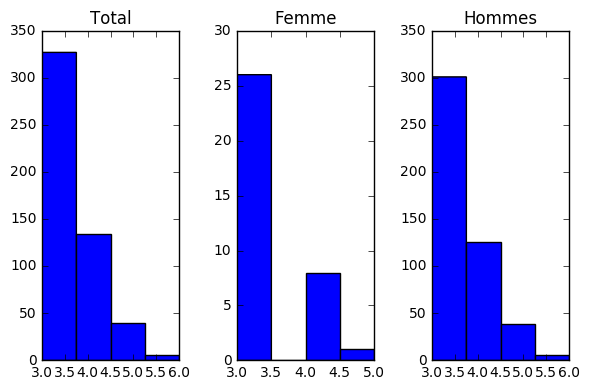

Years
3 years    327
4 years    134
5 years     40
6 years      6
Name: Both, dtype: int64

In [9]:
# Organizing the data, creating subplots and plotting.
a = np.full(three_yrs_tot, 3, dtype=int)
b = np.full(four_yrs_tot, 4, dtype=int)
c = np.full(five_yrs_tot, 5, dtype=int)
d = np.full(six_yrs_tot, 6, dtype=int)
total_population = np.concatenate((a,b,c,d), axis=0)
a = np.full(three_males_tot, 3, dtype=int)
b = np.full(four_males_tot, 4, dtype=int)
c = np.full(five_males_tot, 5, dtype=int)
d = np.full(six_males_tot, 6, dtype=int)
hommes_population = np.concatenate((a,b,c,d), axis=0)
a = np.full(three_females_tot, 3, dtype=int)
b = np.full(four_females_tot, 4, dtype=int)
c = np.full(five_females_tot, 5, dtype=int)
d = np.full(six_females_tot, 6, dtype=int)
femmes_population = np.concatenate((a,b,c,d), axis=0)
fit = stats.norm.pdf(total_population, np.mean(total_population), np.std(total_population))  #this is a fitting indeed
fig = plt.figure()
ax = fig.add_subplot(131)
ax.set_title("Total")
ax.hist(total_population,bins=4)
ax = fig.add_subplot(132)
ax.set_title("Femme")
ax.hist(femmes_population,bins=4) 
ax = fig.add_subplot(133)
ax.set_title("Hommes")
ax.hist(hommes_population,bins=4)
plt.tight_layout()
plt.show() 
total_passed['Both']


For an alfa = 5%, we conclude that they aren't statistically significant

In [10]:
print(stats.ttest_1samp(total_population,np.mean(femmes_population)))
print(stats.ttest_1samp(total_population,np.mean(hommes_population)))
print(stats.ttest_ind(total_population, femmes_population,equal_var=False))
print(stats.ttest_ind(total_population, hommes_population,equal_var=False))


Ttest_1sampResult(statistic=5.5980988793225128, pvalue=3.5578374527603538e-08)
Ttest_1sampResult(statistic=-0.41511326435653323, pvalue=0.67823494381039673)
Ttest_indResult(statistic=1.8506538631054561, pvalue=0.071127270605399848)
Ttest_indResult(statistic=-0.2861118050587948, pvalue=0.77485359017866184)


In [11]:
stats.t.ppf(q=0.025,  # Quantile to check
            df=5)

-2.5705818366147399

In [12]:
stats.t.ppf(q=0.975,  # Quantile to check
            df=5)

2.5705818366147395